In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  #Importamos librerías para usar
import scipy as scp 
from scipy import stats
import seaborn as sns

df = (pd.read_csv("FLIR_groups1and2.csv", sep=";" , header=2))[['Max1R13_1', 'Max1R13_2', 'Max1R13_3', 'Max1R13_4', 
        'aveOralM', 'Gender', 'Age', 'Ethnicity', 'T_atm', 'Humidity', 'Cosmetics']].copy() #cargamos el dataframe

#creamos la nueva columna con el valor promediado de Max1R13
df['Max1R13'] = df[['Max1R13_1', 'Max1R13_2', 'Max1R13_3', 'Max1R13_4']].mean(axis=1, skipna=True).astype(float)
#Eliminamos las columnas de Max1R13 que no son la promediada
df.drop(columns=['Max1R13_1', 'Max1R13_2', 'Max1R13_3', 'Max1R13_4'],inplace=True) 

print(df.isnull().sum()) #Corroboramos si hay datos nulos

#Veamos el comportamiento de los valores nulos de Cosmetics y como podemos tratarlos

        #Primero pasamos los datos a una string pues son categoricos, para poder tratarlos como categoricos 
df["Cosmetics"] = df["Cosmetics"].map({0.0: "No", 1.0: "Sí"}) 

print(f"\nmoda de cosmeticos: {df['Cosmetics'].mode()}")

b=df['Cosmetics'].fillna(df["Cosmetics"].mode())
print(f"mode de cosmeticos imputando con la moda: {b.mode()}\n")

#procedemos a imputar los valores nulos con la mediana

df["Cosmetics"] = df["Cosmetics"].fillna("No")

df.info()

aveOralM      0
Gender        0
Age           0
Ethnicity     0
T_atm         0
Humidity      0
Cosmetics    29
Max1R13       0
dtype: int64

moda de cosmeticos: 0    No
Name: Cosmetics, dtype: object
mode de cosmeticos imputando con la moda: 0    No
Name: Cosmetics, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   aveOralM   1020 non-null   float64
 1   Gender     1020 non-null   object 
 2   Age        1020 non-null   object 
 3   Ethnicity  1020 non-null   object 
 4   T_atm      1020 non-null   float64
 5   Humidity   1020 non-null   float64
 6   Cosmetics  1020 non-null   object 
 7   Max1R13    1020 non-null   float64
dtypes: float64(4), object(4)
memory usage: 63.9+ KB


In [12]:

# Columnas numéricas
df_num = df.select_dtypes(include=[np.number])

# Columnas categóricas (excluimos las numéricas)
df_cat = df.select_dtypes(exclude=[np.number])

metricas_num = pd.DataFrame({ 
    'Media': df_num.mean(), 
    'Mediana': df_num.median(),
    'Moda': df_num.mode().iloc[0],
    'SD': df_num.std(),
    'MAD': scp.stats.median_abs_deviation(df_num),
    'Varianza': df_num.var(),
    'IQR': df_num.quantile(0.75) - df_num.quantile(0.25),
    'CV %': (df_num.std() / df_num.median()),
    'CVM %': (scp.stats.median_abs_deviation(df_num) / df_num.median())
}).T

# Métricas para columnas categóricas: solo la Moda es significativa
indices = ["Media", "Mediana", "Moda", "SD", "MAD", "Varianza", "IQR", "CV %", "CVM %"]
metricas_cat = pd.DataFrame(index=indices, columns=df_cat.columns)
metricas_cat.loc["Moda"] = df_cat.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# Unir ambos DataFrames (las columnas no se traslapan)
metricas_completas = pd.concat([metricas_num, metricas_cat], axis=1)

# Reordenar las columnas según el orden original de df
metricas_completas = metricas_completas[df.columns]

print(metricas_completas)


           aveOralM  Gender    Age Ethnicity      T_atm    Humidity Cosmetics  \
Media     37.028382     NaN    NaN       NaN  24.115392   28.723039       NaN   
Mediana   36.940000     NaN    NaN       NaN  24.000000   26.300000       NaN   
Moda      36.890000  Female  18-20     White  24.000000   30.000000        No   
SD         0.509502     NaN    NaN       NaN   1.336338   13.071627       NaN   
MAD        0.200000     NaN    NaN       NaN   0.600000    8.900000       NaN   
Varianza   0.259593     NaN    NaN       NaN   1.785798  170.867427       NaN   
IQR        0.362500     NaN    NaN       NaN   1.300000   18.600000       NaN   
CV %       0.013793     NaN    NaN       NaN   0.055681    0.497020       NaN   
CVM %      0.005414     NaN    NaN       NaN   0.025000    0.338403       NaN   

            Max1R13  
Media     35.596533  
Mediana   35.548750  
Moda      35.677500  
SD         0.574888  
MAD        0.310000  
Varianza   0.330496  
IQR        0.625000  
CV %       0.

<h1>ANÁLISIS DEL SD Y MAD</h1>
<p>En todos los casos, la desviación estándar es notablemente mayor que la MAD, lo que sugiere la presencia de datos atípicos o una distribución no simétrica. Esto se debe a que la SD es más sensible a valores extremos, mientras que la MAD refleja mejor la dispersión típica sin verse tan afectada por outliers.</p>

<h2>DISPERSIÓN DE LOS DATOS SEGÚN EL COEFICIENTE DE VARIACIÓN</h2>
<p>Las variables aveOralM, T_atm y MaxIR13 tienen coeficientes de variación muy bajos, lo que indica que sus valores están concentrados cerca del valor central (mediana). La variable Humidity tiene un CV elevado (49.7%), lo que indica que es altamente dispersa, y refuerza la posibilidad de que contenga valores atípicos o esté afectada por una distribución sesgada. El coeficiente de variación confirma que, salvo Humidity, las variables están bien concentradas y no muy dispersas.</p>


In [13]:
# Seleccionar únicamente las columnas numéricas
df_numeric = df.select_dtypes(include=[np.number])
datos_atipicos={}
contador_001 = 0
# Recorrer cada columna numérica
for col in df_numeric.columns:
    # Calcular percentiles e IQR una sola vez
    Q1 = np.nanpercentile(df_numeric[col], 25)
    Q3 = np.nanpercentile(df_numeric[col], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    # Imprimir el rango para verificación (opcional)
    print(f"Columna {col}: Lower Bound = {lower_bound}, Upper Bound = {upper_bound}")

        # Detectar e imprimir valores atípicos
    for value in df_numeric[col]:
        if value < lower_bound:
            datos_atipicos[f"{col}_{contador_001}"] = f"{value} es dato atípico en la columna {col} (inferior a {lower_bound})"
            contador_001 += 1
        elif value > upper_bound:
            datos_atipicos[f"{col}_{contador_001}"] = f"{value} es dato atípico en la columna {col} (superior a {upper_bound})"
            contador_001 += 1
print(f"DATOS ATIPICOS:")
datos_atipicos

Columna aveOralM: Lower Bound = 36.23375000000001, Upper Bound = 37.683749999999996
Columna T_atm: Lower Bound = 21.449999999999996, Upper Bound = 26.65
Columna Humidity: Lower Bound = -10.3, Upper Bound = 64.10000000000001
Columna Max1R13: Lower Bound = 34.31000000000002, Upper Bound = 36.80999999999999
DATOS ATIPICOS:


{'aveOralM_0': '37.79 es dato atípico en la columna aveOralM (superior a 37.683749999999996)',
 'aveOralM_1': '36.14 es dato atípico en la columna aveOralM (inferior a 36.23375000000001)',
 'aveOralM_2': '35.99 es dato atípico en la columna aveOralM (inferior a 36.23375000000001)',
 'aveOralM_3': '37.79 es dato atípico en la columna aveOralM (superior a 37.683749999999996)',
 'aveOralM_4': '37.99 es dato atípico en la columna aveOralM (superior a 37.683749999999996)',
 'aveOralM_5': '38.69 es dato atípico en la columna aveOralM (superior a 37.683749999999996)',
 'aveOralM_6': '38.54 es dato atípico en la columna aveOralM (superior a 37.683749999999996)',
 'aveOralM_7': '38.59 es dato atípico en la columna aveOralM (superior a 37.683749999999996)',
 'aveOralM_8': '36.09 es dato atípico en la columna aveOralM (inferior a 36.23375000000001)',
 'aveOralM_9': '37.79 es dato atípico en la columna aveOralM (superior a 37.683749999999996)',
 'aveOralM_10': '38.09 es dato atípico en la columna 

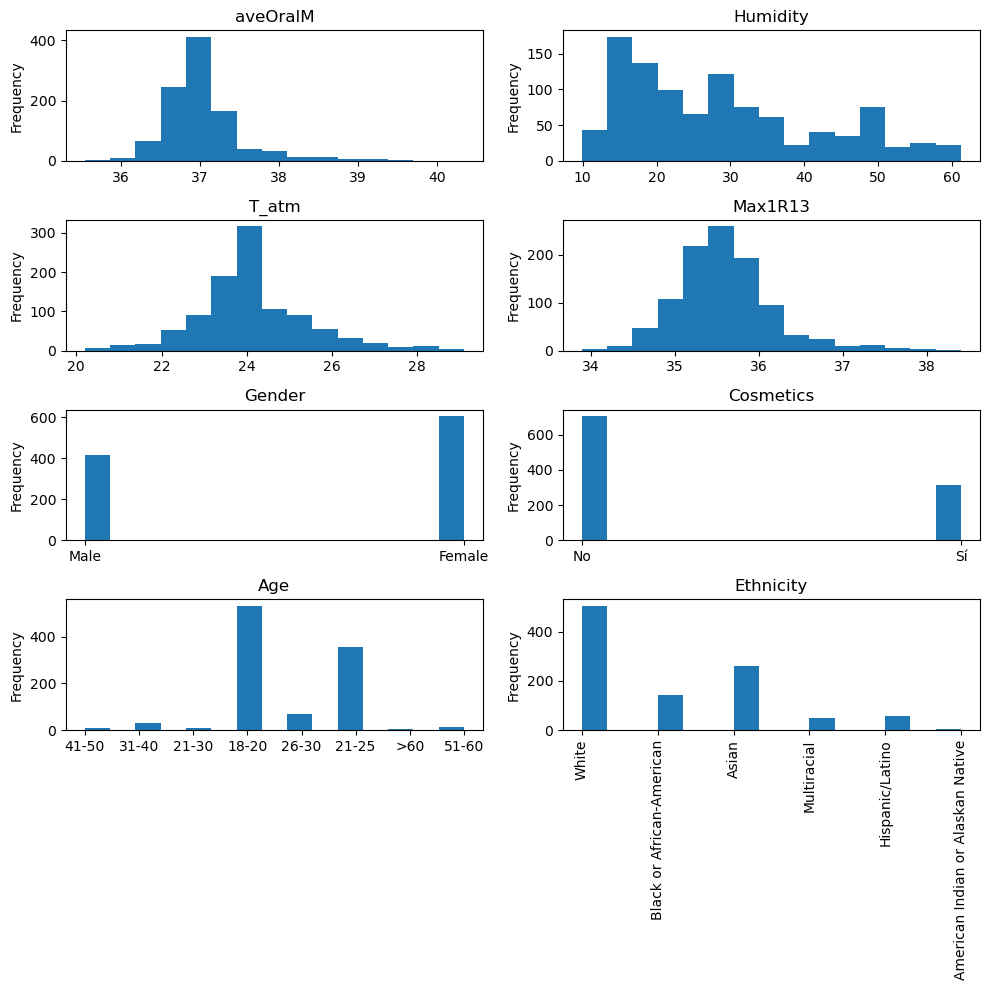

In [14]:
#HISTOGRAMAS

fig, ax = plt.subplots(4,2,figsize=(10,10))

ax[0][0].hist(df['aveOralM'], bins=15)
ax[0][0].set_title("aveOralM")
ax[0][0].set_ylabel("Frequency")

ax[1][0].hist(df['T_atm'], bins=15)
ax[1][0].set_title("T_atm")
ax[1][0].set_ylabel("Frequency")

ax[0][1].hist(df['Humidity'], bins=15)
ax[0][1].set_title("Humidity")
ax[0][1].set_ylabel("Frequency")

ax[1][1].hist(df['Max1R13'], bins=15)
ax[1][1].set_title("Max1R13")
ax[1][1].set_ylabel("Frequency")

ax[2][0].hist(df['Gender'], bins=15)
ax[2][0].set_title("Gender")
ax[2][0].set_ylabel("Frequency")

ax[3][1].hist(df['Ethnicity'], bins=15)
ax[3][1].set_title("Ethnicity")
ax[3][1].set_ylabel("Frequency")
ax[3][1].tick_params(axis='x', rotation=90) 

ax[3][0].hist(df['Age'], bins=15)
ax[3][0].set_title("Age")
ax[3][0].set_ylabel("Frequency")

ax[2][1].hist(df['Cosmetics'], bins=15)
ax[2][1].set_title("Cosmetics")
ax[2][1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

<h1>ANÁLISIS DE LOS HISTOGRAMAS</h1>
<p>La variable aveOralM, que representa el promedio de las temperaturas orales tomadas, muestra un histograma con forma de campana, simétrico y centrado alrededor de su media. La distribución no presenta colas alargadas ni acumulación hacia los extremos, lo que indica que su comportamiento es coherente con una distribución normal. Esto es consistente con sus métricas, ya que la media, la mediana y la moda son muy similares.</p>

<p>En el caso de la variable T_atm (temperatura ambiente), el histograma también refleja una distribución simétrica, sin evidencias claras de sesgo. Aunque la dispersión es ligeramente mayor que en aveOralM, la mayoría de los valores se agrupan alrededor del centro, lo cual también sugiere una distribución normal o aproximadamente normal. Nuevamente, las medidas de tendencia central coinciden en este caso.</p>

<p>La variable Humidity muestra un comportamiento claramente distinto. El histograma revela una acumulación de frecuencias en los valores bajos, con una cola que se extiende hacia los valores altos. Este patrón indica una distribución sesgada a la derecha o positivamente asimétrica. Esta observación concuerda con sus métricas de dispersión, ya que la desviación estándar y el coeficiente de variación son considerablemente altos. Es probable que tenga una distribución no normal.</p>

<p>La variable MaxIR13 presenta un histograma que se asemeja nuevamente a una forma simétrica y centrada, sin colas pronunciadas. La distribución de los datos es estable, lo cual se refleja en sus métricas, ya que posee baja dispersión y las medidas de tendencia central están muy cercanas entre sí. Por tanto, puede considerarse que esta variable también se ajusta a una distribución aproximadamente normal.</p>

<p>En cuanto a las variables categóricas, la variable Género presenta una clara asimetría. El histograma muestra una diferencia marcada entre las dos categorías, con una mayor frecuencia en el grupo femenino. Este comportamiento indica una distribución desequilibrada, que si bien no puede ser normal por tratarse de una variable cualitativa, sí refleja que la muestra no está balanceada en términos de género.</p>

<p>La variable Grupo Edad representa rangos etarios y también es categórica. Su histograma muestra que algunos grupos tienen mayor representación que otros, lo cual indica una distribución no uniforme. Esta asimetría puede responder a la estructura demográfica de la población medida o a cómo se construyó la muestra. En cualquier caso, es importante tener en cuenta este desequilibrio si se planea hacer análisis estratificados o comparaciones entre grupos.</p>

<p>La variable cosmetics, que indica si la persona tenía maquillaje, cremas u otros productos cosméticos al momento de la medición, presenta un histograma altamente asimétrico, con la categoría No muy dominante frente a Si. Este comportamiento sugiere que la gran mayoría de la muestra pertenece solo al grupo de "no tenía cosméticos". Esta variable, aunque dicotómica, tiene un impacto importante en estudios donde la temperatura de la piel se ve afectada por agentes externos, por lo que su distribución sesgada puede ser un factor crítico.</p>

<p>Finalmente, la variable ethnicity, que representa el origen étnico, muestra una distribución categórica también asimétrica. El histograma indica que dos categorías (White y Asian) concentran la mayoría de los casos, mientras que el resto tienen frecuencias muy bajas. Este patrón revela una distribución altamente desequilibrada, lo cual puede limitar la representatividad de ciertos grupos étnicos en los análisis posteriores, especialmente si se desea hacer inferencias por subgrupo.</p>

<p>Las ocho variables analizadas, cuatro son numéricas (aveOralM, T_atm, Humidity, MaxIR13) y muestran un comportamiento mayormente simétrico, salvo Humidity que presenta un claro sesgo a la derecha. Las otras cuatro variables son categóricas (Género, Grupo Edad, cosmetics y ethnicity) y todas exhiben desequilibrios notables en la frecuencia de sus categorías, lo cual es importante tener en cuenta para evitar sesgos en el análisis.</p>

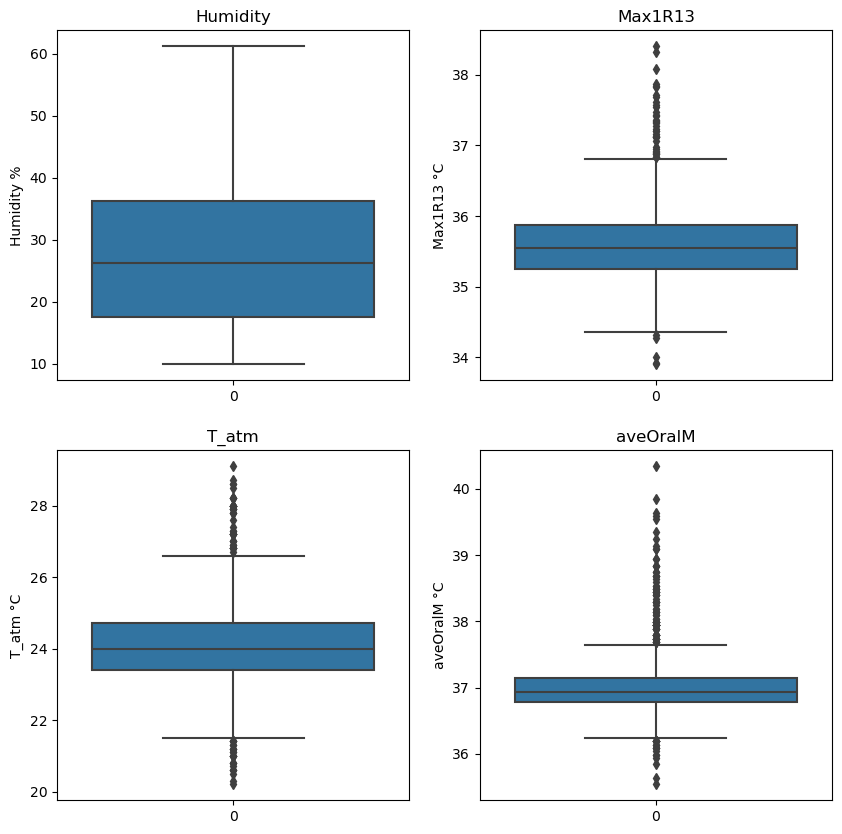

In [20]:
#GRAFICOS DE CAJAS Y BIGOTES

fig, ax = plt.subplots(2,2,figsize=(10,10))

sns.boxplot(data=df_num["Humidity"], ax=ax[0][0])
ax[0][0].set_title('Humidity')
ax[0][0].set_ylabel('Humidity %')

sns.boxplot(data=df_num["Max1R13"], ax=ax[0][1])
ax[0][1].set_title("Max1R13")
ax[0][1].set_ylabel('Max1R13 °C')

sns.boxplot(data=df_num["T_atm"], ax=ax[1][0])
ax[1][0].set_title('T_atm')
ax[1][0].set_ylabel('T_atm °C')

sns.boxplot(data=df_num["aveOralM"], ax=ax[1][1])
ax[1][1].set_title('aveOralM')
ax[1][1].set_ylabel('aveOralM °C')

plt.show()


<h1>ANÁLISIS DE LOS GRÁFICOS DE CAJAS Y BIGOTES</h1>
<p>La distribución de la variable Humidity muestra una ligera asimetría negativa. La mayoría de los valores se concentran entre aproximadamente 18% y 35% de humedad, aunque se observan valores tan bajos como 10% y tan altos como más de 60%. No hay outliers marcados, lo que sugiere una dispersión natural dentro de un rango amplio. Esto indica que las condiciones de humedad varían bastante entre las observaciones, sin valores extremos fuera del patrón general.</p>

<p>La variable Max1R13 tiene una distribución moderadamente asimétrica positiva. La mediana está ligeramente por debajo del centro de la caja, y los outliers son numerosos y concentrados en el extremo superior (más de 37). Esto sugiere que la mayoría de los valores de Max1R13 están en un rango estrecho (entre 34.5 y 36.5 aprox.), pero hay un grupo considerable de valores que se alejan hacia cifras más altas. Esos outliers pueden corresponder a eventos atípicos o picos inusuales del fenómeno medido.</p>

<p>La variable T_atm muestra una mediana bien centrada en la caja, lo cual es un claro indicador de una distribución simétrica. Esto significa que los datos están equilibrados: la mitad de los valores se encuentra por debajo y la otra mitad por encima, de forma bastante uniforme. La caja es algo angosta, lo que indica baja dispersión en los valores centrales. Sin embargo, se observan algunos outliers en ambos extremos, principalmente temperaturas más altas y más bajas de lo habitual. Los bigotes no son excesivamente largos, lo cual confirma que los datos están contenidos en un rango razonable. Esta variable es bastante estable, aunque los valores extremos podrían deberse a días particularmente cálidos o fríos.</p>

<p>La variable aveOralM tiene una distribución ligeramente sesgada hacia la derecha, con muchos outliers en el extremo superior. La caja es muy angosta, lo que indica que la mayoría de los datos están concentrados entre aproximadamente 36.8 y 37.2. Aun así, hay numerosos valores atípicos por encima de 38 y hasta 40, lo que señala que, aunque la mayoría de los casos están en un rango muy estrecho, existen algunos individuos o momentos con valores anormalmente altos. Los outliers podrían representar situaciones excepcionales, errores de medición o personas con fiebre u otros problemas de salud.</p>

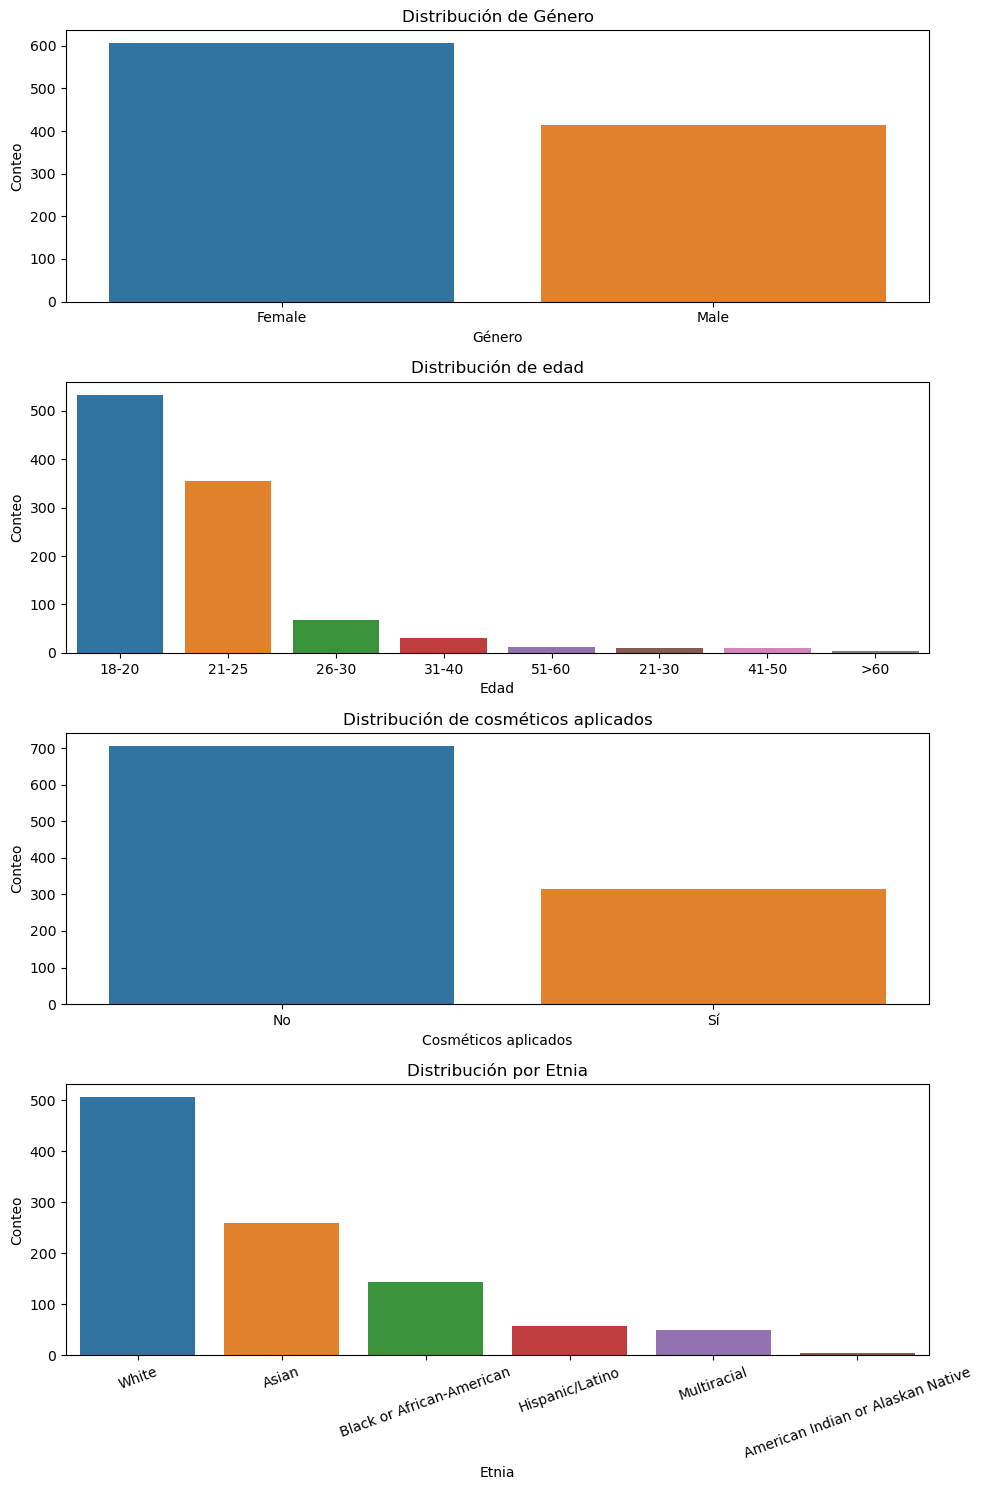

In [21]:
#GRÁFICOS DE BARRA

df_cat["Gender"].value_counts()
df_cat["Age"].value_counts()
df_cat["Cosmetics"].value_counts()
df_cat["Ethnicity"].value_counts()

fig, ax = plt.subplots(4, 1, figsize=(10, 15))


sns.barplot(x=df_cat["Gender"].value_counts().index, 
            y=df_cat["Gender"].value_counts().values, ax=ax[0])
ax[0].set_title("Distribución de Género")
ax[0].set_xlabel("Género")
ax[0].set_ylabel("Conteo")

sns.barplot(x=df_cat["Age"].value_counts().index, 
            y=df_cat["Age"].value_counts().values, ax=ax[1])
ax[1].set_title("Distribución de edad")
ax[1].set_xlabel("Edad")
ax[1].set_ylabel("Conteo")

sns.barplot(x=df_cat["Cosmetics"].value_counts().index, 
            y=df_cat["Cosmetics"].value_counts().values, ax=ax[2])
ax[2].set_title("Distribución de cosméticos aplicados")
ax[2].set_xlabel("Cosméticos aplicados")
ax[2].set_ylabel("Conteo")

sns.barplot(x=df_cat["Ethnicity"].value_counts().index, 
            y=df_cat["Ethnicity"].value_counts().values, ax=ax[3].tick_params(axis='x', rotation=20) )
ax[3].set_title("Distribución por Etnia")
ax[3].set_xlabel("Etnia")
ax[3].set_ylabel("Conteo")

plt.tight_layout()
plt.show()

<h1>ANÁLISIS DE LOS GRÁFICOS DE BARRAS</h1>
<p>El gráfico de distribución de género muestra una mayor proporción de mujeres que hombres en la muestra. Específicamente, el grupo femenino supera las 600 observaciones, mientras que el masculino apenas sobrepasa las 400. Esto indica que el estudio tiene una representación mayoritaria de mujeres, lo cual podría influir en las conclusiones si el género afecta las variables que se están analizando. En investigaciones relacionadas con temas de salud este desequilibrio puede ser relevante.</p>

<p>El gráfico de distribución de edad indica que la mayoría de los participantes están en los grupos etarios más jóvenes. El rango de 18 a 20 años es el más numeroso, con más de 500 personas, seguido del grupo 21 a 25 años, con poco más de 350. A partir de ahí, la frecuencia decrece rápidamente, siendo casi nula en los grupos mayores de 50 años. Esto sugiere que la muestra está fuertemente enfocada en adultos jóvenes, lo cual también puede impactar los resultados, especialmente si se estudian variables sensibles a la edad.</p>

<p>El gráfico de distribución de cosméticos aplicados muestra una clara diferencia entre quienes no usaron cosméticos y quienes sí lo hicieron. Aproximadamente 700 personas no aplicaron cosméticos, mientras que unas 300 sí lo hicieron. Esto implica que dos tercios de la muestra no utilizó cosméticos, por lo que cualquier comparación entre ambos grupos deberá tener en cuenta este desequilibrio de tamaño, que puede afectar el poder estadístico y la interpretación de diferencias.</p>

<p>El gráfico de distribución por etnia indica que la mayoría de los participantes se identifican como White (blancos), con más de 500 individuos. Le siguen Asian (asiáticos) y Black or African-American, aunque con una diferencia notable. Las etnias Hispanic/Latino, Multiracial y American Indian or Alaskan Native tienen una representación muy baja, especialmente esta última. Esto sugiere que la diversidad étnica de la muestra es limitada, y que las conclusiones podrían estar más representativas de ciertas etnias sobre otras. En estudios de salud o características físicas, esto es especialmente importante.</p>

          aveOralM     T_atm  Humidity   Max1R13
aveOralM  1.000000  0.098663  0.063595  0.741902
T_atm     0.098663  1.000000  0.119270  0.275363
Humidity  0.063595  0.119270  1.000000  0.050884
Max1R13   0.741902  0.275363  0.050884  1.000000


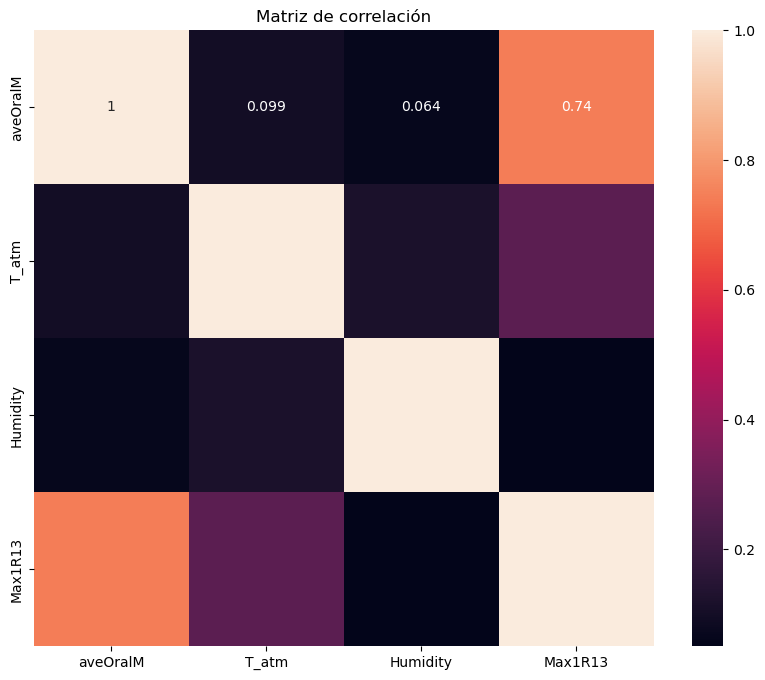

In [22]:
## Matriz de correlacion 

# Calcula la matriz de correlación, que por defecto usa el coeficiente de correlación de Pearson.
correlation_matrix = df_num.corr()

# Muestra la matriz de correlación por consola (opcional)
print(correlation_matrix)

# Visualiza la matriz de correlación con un heatmap de Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.title("Matriz de correlación")
plt.show()


<h1>ANÁLISIS MATRIZ DE CORRELACIÓN</h1>
<p>La correlación más fuerte observada en la matriz es entre aveOralM y Max1R13, con un valor de 0.74. Esta es una correlación positiva alta, lo que indica que cuando aumenta el valor de una de estas variables, también tiende a aumentar la otra. Esto sugiere que existe una relación directa considerable entre estas dos medidas, probablemente porque ambas están relacionadas con valores fisiológicos similares. Esta correlación es lo suficientemente fuerte como para considerar que una variable podría servir como predictor de la otra en un modelo analítico o de regresión.</p>

<p>La segunda correlación más alta, aunque mucho más baja, es entre Max1R13 y T_atm, con un coeficiente de 0.28. Esta es una correlación positiva débil, lo que significa que, aunque hay una ligera tendencia a que ambas variables aumenten juntas, no es una relación fuerte ni necesariamente confiable para hacer predicciones. Sin embargo, podría haber una pequeña influencia del ambiente en el valor de Max1R13.</p>

<p>En tercer lugar, aparece la correlación entre Humidity y T_atm, que es de 0.12. A pesar de ser también una correlación débil, es un poco más alta que otras en la matriz. Esto indica que podría haber una relación ligera entre la humedad y la temperatura atmosférica, lo cual tiene sentido desde un punto de vista físico, aunque los datos disponibles no muestran una conexión fuerte o consistente.</p>

<p>Después encontramos la correlación entre aveOralM y T_atm, con un valor de 0.099, lo que representa una correlación muy baja. Esto indica que la temperatura ambiental prácticamente no influye en la temperatura oral promedio registrada, al menos en este conjunto de datos. Es decir, los cambios en el ambiente no parecen reflejarse directamente en esta medida fisiológica.</p>

<p>La siguiente correlación más baja es la de aveOralM y Humidity, con un valor de 0.064, que indica una correlación prácticamente nula. Esto implica que no hay evidencia de una relación lineal entre la humedad del ambiente y la temperatura oral media, lo que puede deberse a una falta de conexión directa entre estas variables.</p>

<p>Por último, la correlación más baja de todas es la de Humidity y Max1R13, con un valor muy cercano a 0, lo que sugiere una ausencia total de relación lineal entre estas dos variables. En otras palabras, los niveles de humedad no parecen tener ningún tipo de vínculo con los valores registrados en Max1R13.</p> 

<p> La única correlación verdaderamente significativa es entre aveOralM y Max1R13, mientras que las demás relaciones son débiles o despreciables.</p>

<h1> MUESTREO DE LOS DATOS

In [23]:
# Realizar muestreo aleatorio de 500 filas
df_muestra = df.sample(n=500)

# Columnas numéricas
df_mues_num = df_muestra.select_dtypes(include=[np.number])

# Columnas categóricas (excluimos las numéricas)
df_mues_cat = df_muestra.select_dtypes(exclude=[np.number])

metricas_num_muestra = pd.DataFrame({ 
    'Media': df_mues_num.mean(), 
    'Mediana': df_mues_num.median(),
    'Moda': df_mues_num.mode().iloc[0],
    'SD': df_mues_num.std(),
    'MAD': scp.stats.median_abs_deviation(df_mues_num),
    'Varianza': df_mues_num.var(),
    'IQR': df_mues_num.quantile(0.75) - df_mues_num.quantile(0.25),
    'CV %': (df_mues_num.std() / df_mues_num.median()),
    'CVM %': (scp.stats.median_abs_deviation(df_mues_num) / df_mues_num.median())
}).T

# Métricas para columnas categóricas: solo la Moda es significativa
indices = ["Media", "Mediana", "Moda", "SD", "MAD", "Varianza", "IQR", "CV %", "CVM %"]
metricas_cat_muestra = pd.DataFrame(index=indices, columns=df_mues_cat.columns)
metricas_cat_muestra.loc["Moda"] = df_mues_cat.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# Unir ambos DataFrames (las columnas no se traslapan)
metricas_completas_random = pd.concat([metricas_num_muestra, metricas_cat_muestra], axis=1)

# Reordenar las columnas según el orden original de df
metricas_completas = metricas_completas_random[df_muestra.columns]

print(metricas_completas)


           aveOralM  Gender    Age Ethnicity      T_atm    Humidity Cosmetics  \
Media     37.033600     NaN    NaN       NaN  24.077000   28.092200       NaN   
Mediana   36.940000     NaN    NaN       NaN  24.000000   24.400000       NaN   
Moda      36.890000  Female  18-20     White  24.000000   13.500000        No   
SD         0.498634     NaN    NaN       NaN   1.278029   13.279298       NaN   
MAD        0.200000     NaN    NaN       NaN   0.600000    8.650000       NaN   
Varianza   0.248636     NaN    NaN       NaN   1.633358  176.339759       NaN   
IQR        0.400000     NaN    NaN       NaN   1.200000   18.550000       NaN   
CV %       0.013498     NaN    NaN       NaN   0.053251    0.544234       NaN   
CVM %      0.005414     NaN    NaN       NaN   0.025000    0.354508       NaN   

            Max1R13  
Media     35.575108  
Mediana   35.508750  
Moda      35.677500  
SD         0.596002  
MAD        0.320000  
Varianza   0.355218  
IQR        0.631875  
CV %       0.

<h1>COMPARACIÓN DE MÉTRICAS ENTRE EL DATA FRAME ORIGINAL Y EL DE MUESTREO SIMPLE</h1>
<p>Al comparar las métricas estadísticas del data frame original con las del data frame obtenido mediante muestreo simple (n=500), se puede observar que, en general, no existen diferencias significativas entre ambos conjuntos de datos. Esto indica que el muestreo fue efectivo y que la muestra es bastante representativa de la población.</p>

<p>En cuanto a la variable aveOralM (promedio de temperatura oral), tanto la media como la mediana son prácticamente idénticas entre el original y la muestra. La desviación estándar y la varianza también son muy similares, lo cual sugiere que la dispersión de los datos en la muestra refleja adecuadamente la del conjunto completo. Incluso el coeficiente de variación (CV%) se mantiene muy estable. Esto indica que la distribución de esta variable fue bien preservada en la muestra.</p>

<p>La variable Max1R13 también muestra un comportamiento similar. La media y la mediana apenas difieren entre ambos data frames, y aunque la desviación estándar y la varianza presentan una leve variación, esta se mantiene dentro de rangos razonables. El IQR prácticamente no cambia, lo cual refuerza la idea de que la distribución central de los datos se mantuvo intacta.</p>

<p>Con respecto a la temperatura ambiental (T_atm), tanto la media como la mediana son iguales o muy cercanas entre los dos conjuntos, lo que indica que la tendencia central se mantuvo. La desviación estándar y la varianza disminuyen levemente en la muestra, pero siguen reflejando una dispersión coherente con la del conjunto completo de datos. Esto refuerza que la muestra no está sesgada en esta variable.</p>

<p>En la variable Humidity (humedad), las métricas son también muy similares, aunque se observa una pequeña diferencia en la mediana: 26.2 en el conjunto original frente a 24.4 en la muestra. Esta diferencia podría sugerir una ligera subrepresentación de valores altos de humedad en la muestra. Aun así, la media, la desviación estándar y el IQR son prácticamente iguales, lo que sugiere que el patrón general de la variable sigue siendo representativo.</p>

<p>Analizando la moda de las ocho variables, se observa que los valores más frecuentes se mantienen constantes entre el data frame original y el de muestreo simple. Por ejemplo, en variables categóricas como género, edad, etnicidad y uso de cosméticos, las categorías con mayor frecuencia son las mismas en ambos conjuntos. En las variables numéricas, como aveOralM, T_atm, y Max1R13 (excepto Humidity), la moda también coincide, lo que refuerza la idea de que la muestra preserva adecuadamente las características más representativas del conjunto completo.</p>

<p>Las métricas estadísticas del data frame de muestreo simple no difieren en gran medida del data frame original. Esto sugiere que el muestreo fue exitoso y que la muestra obtenida es adecuada para realizar inferencias confiables sobre la población completa. La única pequeña diferencia destacable está en la moda de la humedad, esto no implica un sesgo necesariamente, sino una fluctuación normal propia de un proceso de muestreo aleatorio.</p>

In [24]:
import numpy as np
import pandas as pd

# Supongamos que df tiene una columna 'Age' en formato categórico (strings o categorías).
# Por ejemplo: "18-20", "21-30", "31-40", etc.

# Paso 1: Lista de categorías únicas en Age (ignora nulos si los hubiera)
stratas = df['Age'].dropna().unique()

# Paso 2: Cálculo del tamaño de la muestra total que deseas
N_TOTAL = 500

# Paso 3: Muestreo estratificado manual
df_strat = pd.DataFrame()

for s in stratas:
    # Filtra la subpoblación que pertenece al estrato 's'
    subset = df[df['Age'] == s]
    
    # Calcula cuántas filas tomar de este estrato, proporcional a su tamaño
    n_s = int(len(subset) / len(df) * N_TOTAL)
    
    # Si el estrato es muy pequeño, podrías usar min(len(subset), n_s) para no pasarte
    if n_s > 0:
        df_strat = pd.concat([df_strat, subset.sample(n=n_s, random_state=42)])

# Si por cuestiones de redondeo no llegaste justo a 500, 
# podrías tomar algunos registros adicionales de los estratos más grandes
if len(df_strat) < N_TOTAL:
    faltan = N_TOTAL - len(df_strat)
    # Por simplicidad, puedes tomar el resto de cualquier estrato grande
    # o redistribuirlo de forma proporcional
    estrato_mas_grande = df.groupby('Age').size().idxmax()
    subset = df[df['Age'] == estrato_mas_grande]
    df_strat = pd.concat([df_strat, subset.sample(n=faltan, random_state=99)])

df_strat.reset_index(drop=True, inplace=True)

# df_strat es tu muestra estratificada final con ~500 registros.
import scipy as scp
from scipy import stats

# Columnas numéricas en df_strat
df_strat_num = df_strat.select_dtypes(include=[np.number])

# Columnas categóricas en df_strat
df_strat_cat = df_strat.select_dtypes(exclude=[np.number])

metricas_num_estrat = pd.DataFrame({
    'Media': df_strat_num.mean(),
    'Mediana': df_strat_num.median(),
    'Moda': df_strat_num.mode().iloc[0],
    'SD': df_strat_num.std(),
    'MAD': scp.stats.median_abs_deviation(df_strat_num),
    'Varianza': df_strat_num.var(),
    'IQR': df_strat_num.quantile(0.75) - df_strat_num.quantile(0.25),
    'CV %': (df_strat_num.std() / df_strat_num.median()),
    'CVM %': (scp.stats.median_abs_deviation(df_strat_num) / df_strat_num.median())
}).T

# Métricas para columnas categóricas: solo la Moda es significativa
indices = ["Media", "Mediana", "Moda", "SD", "MAD", "Varianza", "IQR", "CV %", "CVM %"]
metricas_cat_estrat = pd.DataFrame(index=indices, columns=df_strat_cat.columns)
metricas_cat_estrat.loc["Moda"] = df_strat_cat.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# Unir ambos DataFrames (las columnas no se traslapan)
metricas_completas_estrat = pd.concat([metricas_num_estrat, metricas_cat_estrat], axis=1)

# (Opcional) Reordenar columnas si deseas reflejar el mismo orden que df_strat
metricas_completas_estrat = metricas_completas_estrat[df_strat.columns]

print(metricas_completas_estrat)


           aveOralM  Gender    Age Ethnicity      T_atm    Humidity Cosmetics  \
Media     37.033200     NaN    NaN       NaN  24.130200   28.914800       NaN   
Mediana   36.990000     NaN    NaN       NaN  24.000000   27.200000       NaN   
Moda      37.040000  Female  18-20     White  24.000000   13.500000        No   
SD         0.460465     NaN    NaN       NaN   1.349589   13.022725       NaN   
MAD        0.200000     NaN    NaN       NaN   0.650000    9.600000       NaN   
Varianza   0.212028     NaN    NaN       NaN   1.821391  169.591364       NaN   
IQR        0.350000     NaN    NaN       NaN   1.300000   18.975000       NaN   
CV %       0.012448     NaN    NaN       NaN   0.056233    0.478777       NaN   
CVM %      0.005407     NaN    NaN       NaN   0.027083    0.352941       NaN   

            Max1R13  
Media     35.576240  
Mediana   35.528750  
Moda      35.710000  
SD         0.538400  
MAD        0.291250  
Varianza   0.289875  
IQR        0.583125  
CV %       0.